# Visualization of Segmentation and Registration Results <a href="https://mybinder.org/v2/gh/InsightSoftwareConsortium/SimpleITK-Notebooks/master?filepath=Python%2F05_Results_Visualization.ipynb"><img style="float: right;" src="https://mybinder.org/badge_logo.svg"></a>

In this notebook we illustrate various ways one can display the results of segmentation and registration algorithms so that they can be easily incorporated into a manuscript. For interactive data exploration we recommend using dedicated programs (e.g. 3D slicer). 

Two key points to remember when working with bio-medical images:

1. Most often images have a high dynamic range. Thus, to write them to file in a format appropriate for use in a manuscript we will need to map the intensities to a low dynamic range (e.g. [0,255]). In SimpleITK this is readily done with the [IntensityWindowingImageFilter](https://simpleitk.org/doxygen/latest/html/classitk_1_1simple_1_1IntensityWindowingImageFilter.html).
2. Images may have non-isotropic spacing between pixels. The file formats appropriate for use in a manuscript (e.g. png, jpg) assume isotropic pixel spacing. This requires that we resample the image before writing to disk. The function `make_isotropic` in the code cell bellow resolves this issue. 

The following filters and their procedural counterparts are useful for various image creation tasks, as illustrated in this notebook:
 * [CastImageFilter](https://simpleitk.org/doxygen/latest/html/classitk_1_1simple_1_1CastImageFilter.html)
 * [ResampleImageFilter](https://simpleitk.org/doxygen/latest/html/classitk_1_1simple_1_1ResampleImageFilter.html), one of the more important filters in your toolbox, see [this notebook](21_Transforms_and_Resampling.ipynb) for additional usage details.
 * [TileImageFilter](https://simpleitk.org/doxygen/latest/html/classitk_1_1simple_1_1TileImageFilter.html)
 * [CheckerBoardImageFilter](https://simpleitk.org/doxygen/latest/html/classitk_1_1simple_1_1CheckerBoardImageFilter.html)
 * [ComposeImageFilter](https://simpleitk.org/doxygen/latest/html/classitk_1_1simple_1_1ComposeImageFilter.html)
 * [LabelToRGBImageFilter](https://simpleitk.org/doxygen/latest/html/classitk_1_1simple_1_1LabelToRGBImageFilter.html)
 * [ScalarToRGBColormapImageFilter](https://simpleitk.org/doxygen/latest/html/classitk_1_1simple_1_1ScalarToRGBColormapImageFilter.html)
 * [LabelOverlayImageFilter](https://simpleitk.org/doxygen/latest/html/classitk_1_1simple_1_1LabelOverlayImageFilter.html)
 * [LabelContourImageFilter](https://simpleitk.org/doxygen/latest/html/classitk_1_1simple_1_1LabelContourImageFilter.html)
 * [LabelMapContourOverlayImageFilter](https://simpleitk.org/doxygen/latest/html/classitk_1_1simple_1_1LabelMapContourOverlayImageFilter.html)

In [1]:
%matplotlib inline

import numpy as np
import itertools
import SimpleITK as sitk

# Utility method that either downloads data from the Girder repository or
# if already downloaded returns the file name for reading from disk (cached data).
%run update_path_to_download_script
from downloaddata import fetch_data as fdata

from ipywidgets import interact, fixed
import matplotlib.pyplot as plt
import gui

# Always write output to a separate directory, we don't want to pollute the source directory.
import os

OUTPUT_DIR = "Output"


def make_isotropic(
    image,
    interpolator=sitk.sitkLinear,
    spacing=None,
    default_value=0,
    standardize_axes=False,
):
    """
    Many file formats (e.g. jpg, png,...) expect the pixels to be isotropic, same
    spacing for all axes. Saving non-isotropic data in these formats will result in
    distorted images. This function makes an image isotropic via resampling, if needed.
    Args:
        image (SimpleITK.Image): Input image.
        interpolator: By default the function uses a linear interpolator. For
                      label images one should use the sitkNearestNeighbor interpolator
                      so as not to introduce non-existant labels.
        spacing (float): Desired spacing. If none given then use the smallest spacing from
                         the original image.
        default_value (image.GetPixelID): Desired pixel value for resampled points that fall
                                          outside the original image (e.g. HU value for air, -1000,
                                          when image is CT).
        standardize_axes (bool): If the original image axes were not the standard ones, i.e. non
                                 identity cosine matrix, we may want to resample it to have standard
                                 axes. To do that, set this paramter to True.
    Returns:
        SimpleITK.Image with isotropic spacing which occupies the same region in space as
        the input image.
    """
    original_spacing = image.GetSpacing()
    # Image is already isotropic, just return a copy.
    if all(spc == original_spacing[0] for spc in original_spacing):
        return sitk.Image(image)
    # Make image isotropic via resampling.
    original_size = image.GetSize()
    if spacing is None:
        spacing = min(original_spacing)
    new_spacing = [spacing] * image.GetDimension()
    new_size = [
        int(round(osz * ospc / spacing))
        for osz, ospc in zip(original_size, original_spacing)
    ]
    new_direction = image.GetDirection()
    new_origin = image.GetOrigin()
    # Only need to standardize axes if user requested and the original
    # axes were not standard.
    if standardize_axes and not np.array_equal(
        np.array(new_direction), np.identity(image.GetDimension()).ravel()
    ):
        new_direction = np.identity(image.GetDimension()).ravel()
        # Compute bounding box for the original, non standard axes image.
        boundary_points = []
        for boundary_index in list(
            itertools.product(*zip([0] * image.GetDimension(), image.GetSize()))
        ):
            boundary_points.append(image.TransformIndexToPhysicalPoint(boundary_index))
        max_coords = np.max(boundary_points, axis=0)
        min_coords = np.min(boundary_points, axis=0)
        new_origin = min_coords
        new_size = (((max_coords - min_coords) / spacing).round().astype(int)).tolist()
    return sitk.Resample(
        image,
        new_size,
        sitk.Transform(),
        interpolator,
        new_origin,
        new_spacing,
        new_direction,
        default_value,
        image.GetPixelID(),
    )


def write_video_data(image, output_name, reslice_axis=2, fps=None):
    """
    Create a video clip scrolling through a 3D image along a specific axis and
    write the result to disk. The result can be either the individual frames
    or a video clip. The later depends on OpenCV which is not installed by
    default. The former needs to be assembled into a video using an external tool
    (e.g. ffmpeg).
    Args:
        image (SimpleITK.Image): 3D input image.
                                 NOTE: Pixel spacings in the non-scrolling axes
                                       are expected to be the same (isotropic in
                                       that plane). Use the make_isotropic function
                                       if they aren't.
                                       Pixel type is either sitkUInt8 or sitkVectorUInt8
                                       with three components which are assumed to be RGB.
        output_name (str): A file name prefix. If the frames-per-second parameter is None then this is
                           used as the prefix for saving individual frames in png format. Otherwise,
                           this is used as the prefix for saving the video in mp4 format.
        reslice_axis (int): Number in [0,1,2]. The axis along which we scroll.
        fps (int): Frames per second.
    """
    # Frames are always along the third axis, so set the axis of interest to be the
    # third axis via PermuteAxes
    permute_axes = [0, 1, 2]
    permute_axes[2] = reslice_axis
    permute_axes[reslice_axis] = 2
    image = sitk.PermuteAxes(image, permute_axes)

    if fps is None:  # write slices as individual frames
        sitk.WriteImage(
            image, [f"{output_name}{i:03d}.png" for i in range(image.GetDepth())]
        )
    else:  # use OpenCV to write slices as mp4 video
        video_writer = cv2.VideoWriter(
            filename=output_name + ".mp4",
            fourcc=cv2.VideoWriter_fourcc("m", "p", "4", "v"),
            fps=fps,
            frameSize=image.GetSize()[0:2],
            isColor=image.GetNumberOfComponentsPerPixel() == 3,
        )
        for i in range(image.GetDepth()):
            video_writer.write(sitk.GetArrayViewFromImage(image[:, :, i]))
        video_writer.release()

## Combining two images

There are a variety of ways we can overlay two (partially) overlapping images onto each other. The common approaches include:
1. Use of alpha blending.
2. Use of a checkerboard pattern with the pixel values in adjacent squares/boxes taken from each of the images.
3. When the pixel values are scalars (gray scale images), combine the two images in different channels, resulting in a color image.

We will start by loading two images whose content luckily overlaps in physical space. Before we can combine the two, we need to resample one of them so that they both occupy the same spatial region. In addition we should also rescale the intensities so that they occupy the same range. In our case we will map them to [0,255], based on the desired windowing.

In [ ]:
img1 = sitk.ReadImage(fdata("training_001_mr_T1.mha"))
img2_original = sitk.ReadImage(fdata("training_001_ct.mha"))
img2 = sitk.Resample(img2_original, img1)

# Obtain foreground masks for the two images using Otsu thresholding, we use these later on.
msk1 = sitk.OtsuThreshold(img1, 0, 1)
msk2 = sitk.OtsuThreshold(img2, 0, 1)

gui.MultiImageDisplay(
    image_list=[img1, img2], title_list=["image1", "image2"], figure_size=(9, 3)
);

In [ ]:
# Having identified the desired intensity range for each of the
# images using the GUI above, we use these values to perform intensity windowing and map the intensity values
# to [0,255] and cast to 8-bit unsigned int
img1_255 = sitk.Cast(
    sitk.IntensityWindowing(
        img1, windowMinimum=2, windowMaximum=657, outputMinimum=0.0, outputMaximum=255.0
    ),
    sitk.sitkUInt8,
)
img2_255 = sitk.Cast(
    sitk.IntensityWindowing(
        img2,
        windowMinimum=-1018,
        windowMaximum=1126,
        outputMinimum=0.0,
        outputMaximum=255.0,
    ),
    sitk.sitkUInt8,
)

### Alpha blending

Alpha blending combines the pixels from the two images as follows:
$$
I_{output} = \alpha I_1 + (1-\alpha)I_2,\;\;\; \alpha \in[0.0,1.0]
$$

The $\alpha$ value can be per the whole image or on a per pixel basis.

When our images consist of a foreground and background we can use alpha blending in a manner that takes this into account. Instead of blending all of the pixels using the formula above, we use this formula only in the regions where the foregrounds overlap. In regions where the foreground from one image overlaps with the background of the other we simply copy the foreground. This improves visibility as we are not blending a region that contains information with an empty region.

The code below allows us to experiment with various alpha blending strategies.

In [ ]:
def mask_image_multiply(mask, image):
    components_per_pixel = image.GetNumberOfComponentsPerPixel()
    if components_per_pixel == 1:
        return mask * image
    else:
        return sitk.Compose(
            [
                mask * sitk.VectorIndexSelectionCast(image, channel)
                for channel in range(components_per_pixel)
            ]
        )


def alpha_blend(image1, image2, alpha=0.5, mask1=None, mask2=None):
    """
    Alaph blend two images, pixels can be scalars or vectors.
    The alpha blending factor can be either a scalar or an image whose
    pixel type is sitkFloat32 and values are in [0,1].
    The region that is alpha blended is controled by the given masks.
    """

    if not mask1:
        mask1 = sitk.Image(image1.GetSize(), sitk.sitkFloat32) + 1.0
        mask1.CopyInformation(image1)
    else:
        mask1 = sitk.Cast(mask1, sitk.sitkFloat32)
    if not mask2:
        mask2 = sitk.Image(image2.GetSize(), sitk.sitkFloat32) + 1
        mask2.CopyInformation(image2)
    else:
        mask2 = sitk.Cast(mask2, sitk.sitkFloat32)
    # if we received a scalar, convert it to an image
    if type(alpha) != sitk.SimpleITK.Image:
        alpha = sitk.Image(image1.GetSize(), sitk.sitkFloat32) + alpha
        alpha.CopyInformation(image1)
    components_per_pixel = image1.GetNumberOfComponentsPerPixel()
    if components_per_pixel > 1:
        img1 = sitk.Cast(image1, sitk.sitkVectorFloat32)
        img2 = sitk.Cast(image2, sitk.sitkVectorFloat32)
    else:
        img1 = sitk.Cast(image1, sitk.sitkFloat32)
        img2 = sitk.Cast(image2, sitk.sitkFloat32)

    intersection_mask = mask1 * mask2

    intersection_image = mask_image_multiply(
        alpha * intersection_mask, img1
    ) + mask_image_multiply((1 - alpha) * intersection_mask, img2)
    return (
        intersection_image
        + mask_image_multiply(mask2 - intersection_mask, img2)
        + mask_image_multiply(mask1 - intersection_mask, img1)
    )

We now create 3D images using all four combinations of alpha-blending and masks. As we are working with a 3D image and we want to save it as a figure for use in a manuscript, we will create a 2D montage image using the axial slices from the volumes.

In [ ]:
# Combine the two volumes
images_list = [
    (alpha_blend(img1_255, img2_255), "alpha_blend_standard"),
    (alpha_blend(img1_255, img2_255, mask1=msk1), "alpha_blend_mask1"),
    (alpha_blend(img1_255, img2_255, mask2=msk2), "alpha_blend_mask2"),
    (
        alpha_blend(img1_255, img2_255, mask1=msk1, mask2=msk2),
        "alpha_blend_mask1_mask2",
    ),
]

# Tile the volumes using the x-y plane (axial slices)
all_montages = []
for img, img_name in images_list:
    num_slices = img.GetDepth()
    tile_w = int(np.sqrt(num_slices))
    tile_h = int(np.ceil(num_slices / tile_w))
    tile_image = sitk.Tile([img[:, :, i] for i in range(num_slices)], (tile_w, tile_h))
    sitk.WriteImage(
        sitk.Cast(tile_image, sitk.sitkUInt8),
        os.path.join(OUTPUT_DIR, img_name + ".png"),
    )
    all_montages.append(tile_image)

# Display all montages by combining them into a faux volume. Notice that scrolling through this
# volume creates the illusion of motion due to the change in intensities (the interested
# reader is referred to "Visual dissociations of movement, position, and stereo depth: Some phenomenal
# phenomena", R. L. Gregory, P. F. Heard).
gui.MultiImageDisplay(
    image_list=[sitk.JoinSeries(all_montages)],
    title_list=["Montages With Different Alpha Blending Strategies"],
    figure_size=(8, 8),
);

In the next cell, instead of as a montage, we save each 3D image as a video or video frames, scrolling along a user specified axis. This is useful for presentations.

In [ ]:
# Select the axis along which we scroll. For a correct video rendering the spacing on the other
# two axes is expected to be equal. If it isn't we can always call the make_isotropic function
# defined above.
scroll_axis = 2

# if OpenCV is installed (by default it isn't) save as mp4 videos
try:
    import cv2

    for img, img_name in images_list:
        write_video_data(
            sitk.Cast(img, sitk.sitkUInt8),
            os.path.join(OUTPUT_DIR, img_name),
            reslice_axis=scroll_axis,
            fps=15,
        )
except ImportError:
    for img, img_name in images_list:
        write_video_data(
            sitk.Cast(img, sitk.sitkUInt8),
            os.path.join(OUTPUT_DIR, img_name + "_frame"),
            reslice_axis=scroll_axis,
        )

### Checkerboard

Combine the original and the intensity windowed images using the checkerboard pattern. This illustrates the need to map both images to the same intensity range. This is particularly visible in the background region, where both images contain air. 

You can specify the number of checkerboard tiles per dimension as illustrated below. The actual number of checkerboard tiles depends on the number of pixels per dimension and the specified number of tiles. You may get more tiles than specified, for example try specifying [4,4,7] below.

In [ ]:
gui.MultiImageDisplay(
    image_list=[
        sitk.CheckerBoard(img1, img2, [4, 4, 4]),
        sitk.CheckerBoard(img1_255, img2_255, (10, 10, 4)),
    ],
    title_list=["original intensities", "rescaled intensities"],
    figure_size=(9, 3),
);

### Combine scalar images to create color image

There are a variety of ways we can combine the scalar images to create a color image. Some of these combinations should be avoided as they are not discernible by a significant portion of the population (i.e. red-green channel encoding). For additional details see:

M. Geissbuehler, T. Lasser, "How to display data by color schemes compatible with red-green color perception deficiencies", Opt Express., 21(8):9862-74, 2013.  




In [ ]:
zeros = sitk.Image(img1_255.GetSize(), img1_255.GetPixelID())
zeros.CopyInformation(img1_255)

gui.MultiImageDisplay(
    image_list=[
        sitk.Cast(sitk.Compose(img1_255, img2_255, zeros), sitk.sitkVectorUInt8),
        sitk.Cast(sitk.Compose(img1_255, img2_255, img1_255), sitk.sitkVectorUInt8),
        sitk.Cast(
            sitk.Compose(img1_255, 0.5 * img1_255 + 0.5 * img2_255, img2_255),
            sitk.sitkVectorUInt8,
        ),
    ],
    title_list=["avoid red-green", "use magenta-green", "use orange-blue"],
    figure_size=(9, 3),
);

### Overlay scalar image onto another via color map

In some situations we have an underlying image (spatial structures) and we want to overlay a scalar based pseudo-color image on top of it.

This is relevant for presenting co-registered PET/CT data, with the PET providing functional information and the CT providing the underlying spatial structures. A similar use case in the context of deep learning is to display activation maps illustrating the regions in an image on which the network is focusing its attention for the particular class.

The two main decisions we make are:
1. Selection of pseudo-color scheme using the [ScalarToRGBColormapImageFilter](https://simpleitk.org/doxygen/latest/html/classitk_1_1simple_1_1ScalarToRGBColormapImageFilter.html) which supports a variety of color maps.
2. Alpha blending approach (alpha value per whole image or per pixel, and usage of masks as done above).


In [ ]:
color_maps = {
    "Red": sitk.ScalarToRGBColormapImageFilter.Red,
    "Green": sitk.ScalarToRGBColormapImageFilter.Green,
    "Blue": sitk.ScalarToRGBColormapImageFilter.Blue,
    "Grey": sitk.ScalarToRGBColormapImageFilter.Grey,
    "Hot": sitk.ScalarToRGBColormapImageFilter.Hot,
    "Cool": sitk.ScalarToRGBColormapImageFilter.Cool,
    "Spring": sitk.ScalarToRGBColormapImageFilter.Spring,
    "Summer": sitk.ScalarToRGBColormapImageFilter.Summer,
    "Autumn": sitk.ScalarToRGBColormapImageFilter.Autumn,
    "Winter": sitk.ScalarToRGBColormapImageFilter.Winter,
    "Copper": sitk.ScalarToRGBColormapImageFilter.Copper,
    "Jet": sitk.ScalarToRGBColormapImageFilter.Jet,
    "HSV": sitk.ScalarToRGBColormapImageFilter.HSV,
    "OverUnder": sitk.ScalarToRGBColormapImageFilter.OverUnder,
}


def colormap_dropdown_callback(colormap_name, colormaps_dict, scalar_image):
    global overlay_color_img
    overlay_color_img = sitk.ScalarToRGBColormap(
        scalar_image, colormaps_dict[colormap_name]
    )
    displayed_image = (
        overlay_color_img[:, :, overlay_color_img.GetDepth() // 2]
        if overlay_color_img.GetDimension() == 3
        else overlay_color_img
    )
    fig = plt.figure()
    plt.imshow(sitk.GetArrayViewFromImage(displayed_image))
    plt.axis("off")
    fig.canvas.draw_idle()


# Create a signed distance map which we will overlay onto the original image using
# pseudo-coloring. We are only interested in locations that are at a distance of [0,512] from the object
distance_map = sitk.SignedMaurerDistanceMap(msk1)
# Get binary region of interest mask.
roi = sitk.Cast(distance_map > 0.0, sitk.sitkFloat32) * sitk.Cast(
    distance_map < 512.0, sitk.sitkFloat32
)
roi_distance_map = roi * distance_map

overlay_color_img = None
interact(
    colormap_dropdown_callback,
    colormap_name=list(color_maps.keys()),
    colormaps_dict=fixed(color_maps),
    scalar_image=fixed(roi_distance_map),
);

In [ ]:
# To see the various options, re-run this cell and change the blending_approach (basic, mask, per_pixel_alpha)
blending_approach = "basic"

if blending_approach == "basic":
    combined_volume = sitk.Cast(
        alpha_blend(sitk.Compose(img1_255, img1_255, img1_255), overlay_color_img),
        sitk.sitkVectorUInt8,
    )
elif blending_approach == "mask":
    combined_volume = sitk.Cast(
        alpha_blend(
            sitk.Compose(img1_255, img1_255, img1_255), overlay_color_img, mask2=roi
        ),
        sitk.sitkVectorUInt8,
    )
elif blending_approach == "per_pixel_alpha":
    mmFilter = sitk.MinimumMaximumImageFilter()
    mmFilter.Execute(roi_distance_map)
    alpha = sitk.Cast(
        1.0
        - (roi_distance_map - mmFilter.GetMinimum())
        / (mmFilter.GetMaximum() - mmFilter.GetMinimum()),
        sitk.sitkFloat32,
    )
    combined_volume = sitk.Cast(
        alpha_blend(
            sitk.Compose(img1_255, img1_255, img1_255), overlay_color_img, alpha=alpha
        ),
        sitk.sitkVectorUInt8,
    )

# Given a volume we can either create a montage as above or we can take a representative
# slice (axial/sagittal/coronal). As image formats used in manuscripts assume isotropic
# pixels we need to ensure this before we write to disk.
all_central_slices = [
    combined_volume[:, :, int(combined_volume.GetDepth() / 2.0 + 0.5)],
    combined_volume[:, int(combined_volume.GetHeight() / 2.0 + 0.5), :],
    combined_volume[int(combined_volume.GetWidth() / 2.0 + 0.5), :, :],
]

# Resample to isotropic pixels and write to file.
for i, img in enumerate(all_central_slices):
    all_central_slices[i] = make_isotropic(img)
    sitk.WriteImage(
        all_central_slices[i], os.path.join(OUTPUT_DIR, f"color_overlay{i}.png")
    )

gui.multi_image_display2D(
    [sitk.Tile(all_central_slices, (1, 3))], figure_size=(4, 4), horizontal=False
);

## Combining an image and segmentation

To display the results of segmentation in context, we need to overlay them onto the original image. There are two common options for doing this:
  1. Map the segmentation labels to a color image and alpha blend onto the original image.
  2. Overlay the segmentation boundaries onto the original image.

We illustrate both approaches below.

For this example we use the Point-validated Pixel-based Breathing Thorax Model (POPI) model. The model is provided by the Léon Bérard Cancer Center & CREATIS Laboratory, Lyon, France. The relevant publication is:

J. Vandemeulebroucke, D. Sarrut, P. Clarysse, "The POPI-model, a point-validated pixel-based breathing thorax model", Proc. XVth International Conference on the Use of Computers in Radiation Therapy (ICCR), Toronto, Canada, 2007.

Fetching POPI/meta/00-P.mhd
Fetching POPI/masks/00-air-body-lungs.mhd


<Figure size 640x480 with 0 Axes>

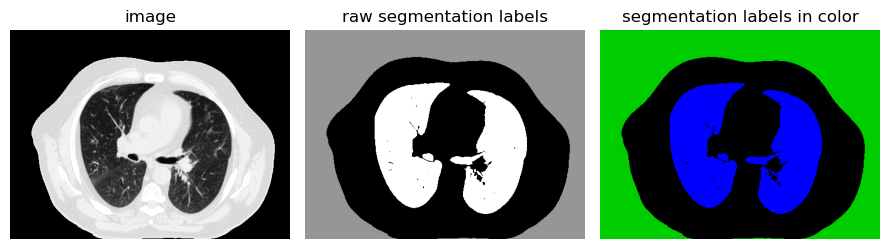

In [3]:
# Load utilities that are specific to the POPI data, the label values associated with the segmentation.
%run popi_utilities_setup.py

img = sitk.ReadImage(fdata("POPI/meta/00-P.mhd"))
segmentation = sitk.ReadImage(fdata("POPI/masks/00-air-body-lungs.mhd"))

gui.MultiImageDisplay(
    image_list=[img, segmentation, sitk.LabelToRGB(segmentation)],
    title_list=["image", "raw segmentation labels", "segmentation labels in color"],
    figure_size=(9, 3),
    shared_slider=True,
); # sliders do not work. needs widgets?

We will work with the central coronal slice from this dataset.

In [4]:
# Identify the desired intensity range for our image using the GUI above, mapping the high dynamic range
# image to a low dynamic range, [0,255], extract the central coronal slice and we flip it for display purposes.
coronal_255 = sitk.Cast(
    sitk.IntensityWindowing(
        img[:, int(img.GetHeight() / 2), :][:, ::-1],
        windowMinimum=-1000,
        windowMaximum=170,
        outputMinimum=0.0,
        outputMaximum=255.0,
    ),
    sitk.sitkUInt8,
)
coronal_255_isotropic = make_isotropic(coronal_255)

coronal_segmentation = segmentation[:, int(segmentation.GetHeight() / 2), :][:, ::-1]
# Use nearest neighbor interpolation for a label image.
coronal_segmentation_isotropic = make_isotropic(
    coronal_segmentation, sitk.sitkNearestNeighbor
)

In many cases the values in a label image are not appropriate for direct display. For instance the values in our
label image are 0,1,2. You can see the values if you hover your cursor over the raw segmentation label image above (figure's bottom right corner). 

In theory we could map these intensities to [0,255] and save the image. In practice we may have more than 256 labels and therefor it is preferable to map the labels to colors and save the color image.

In [5]:
# Use the default color map when mapping labels to colors and write the image.
sitk.WriteImage(
    sitk.LabelToRGB(coronal_segmentation_isotropic),
    os.path.join(OUTPUT_DIR, "coronal_segmentation.png"),
)

### Overlay segmentation labels onto original image

SimpleITK allows you to overlay the segmentation labels onto the original image using a color map and alpha blending. You can specify the value for alpha blending, the color map (there is a default color map), and the background label value which will not be overlaid with a label.

The color map in SimpleITK is a set of values in the RGB color space strung together. For example [255, 0, 0, 0, 255, 0] is a two entry color map with red and green. To create a human readable color map, use lists to represent the colors and string them together, as done below.

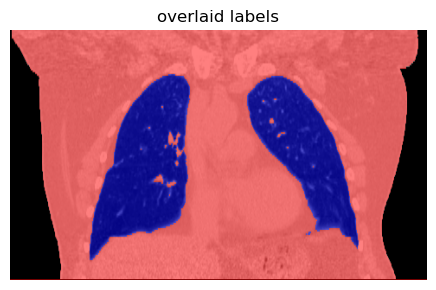

In [6]:
# Overlay the segmentation using default color map and an alpha value of 0.5
coronal_combined1 = sitk.LabelOverlay(
    image=coronal_255_isotropic,
    labelImage=coronal_segmentation_isotropic,
    opacity=0.5,
    backgroundValue=air_label,
)

# Create an "interesting" color map and specify backgroundValue to a non existent label
# so that the background label is also overlaid.
pink = [255, 105, 180]
green = [0, 255, 0]
gold = [255, 215, 0]
coronal_combined2 = sitk.LabelOverlay(
    image=coronal_255_isotropic,
    labelImage=coronal_segmentation_isotropic,
    opacity=0.5,
    backgroundValue=-1.0,
    colormap=pink + green + gold,
)

# Display the two images as a faux volume, JoinSeries, approach.
gui.MultiImageDisplay(
    image_list=[sitk.JoinSeries([coronal_combined1, coronal_combined2])],
    title_list=["overlaid labels"],
    figure_size=(9, 3),
    shared_slider=True,
);

### Overlay segmentation boundaries onto original image

We can readily obtain the segmentation boundaries from the raw segmentation. We then either just save the contours as an image or we can directly overly them onto the image. 

Some points to note:
 1. When working with 3D images and segmentations, our boundaries are surfaces. When these surfaces are intersected  with 2D planes they may define a region and not a contour, which is what we usually expect (e.g. slice 24 in the results displayed by the following code cell).
 2. When the labels are next to each other, they share a boundary. As a consequence, drawing the boundaries may result in contours overwriting each other or in contour crossings.

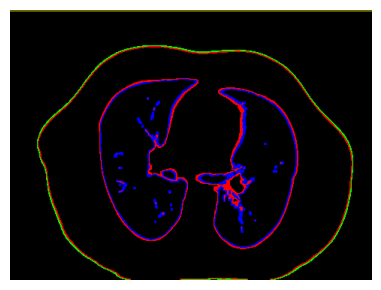

In [7]:
red = [255, 0, 0]
green = [0, 255, 0]
blue = [0, 0, 255]

# red goes to the first label, green to second, blue to third
# body_label=0, air_label=1, lung_label=2
contour_image = sitk.LabelToRGB(
    sitk.LabelContour(segmentation, fullyConnected=True, backgroundValue=255),
    colormap=red + green + blue,
    backgroundValue=255,
)
gui.MultiImageDisplay(image_list=[contour_image], figure_size=(9, 3));

In the following code cell we overlay the contours onto the original image. We use a filter that is intended for usage with a label-map image as opposed to a label image. The former is a more efficient data structure for representing segmentations (run length encoded). We therefor need to cast the label image to a label-map image.
We can also set several visualization related parameters such as overlay opacity, contour thickness, priority of overlay (which label overwrites which if they overlap) etc.

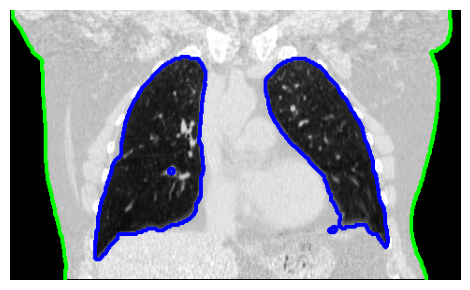

In [8]:
contour_overlaid_image = sitk.LabelMapContourOverlay(
    sitk.Cast(coronal_segmentation_isotropic, sitk.sitkLabelUInt8),
    coronal_255_isotropic,
    opacity=1,
    contourThickness=[4, 4],
    dilationRadius=[3, 3],
    colormap=red + green + blue,
)
gui.multi_image_display2D([contour_overlaid_image], figure_size=(6, 3));

## Comparing two segmentations

In this section we show how to create a binary image illustrating all the locations where two segmentations differ. This is a trivial one liner in SimpleITK.

The following cell modifies our original coronal segmentation by dilating the body region in the top half of the image and dilating the lung region in the bottom half of the image.

In [ ]:
binary_dilate_filter = sitk.BinaryDilateImageFilter()
binary_dilate_filter.SetKernelRadius(2)
mid_size = int(coronal_segmentation_isotropic.GetHeight() / 2)

# Over-segment the body region on the upper image region.
binary_dilate_filter.SetForegroundValue(body_label)
top_segmentation = binary_dilate_filter.Execute(
    coronal_segmentation_isotropic[:, 0:mid_size]
)
# Over-segment the lung region on the lower image region.
binary_dilate_filter.SetForegroundValue(lung_label)
bottom_segmentation = binary_dilate_filter.Execute(
    coronal_segmentation_isotropic[:, mid_size:]
)

modified_segmentation = sitk.Tile(top_segmentation, bottom_segmentation, (1, 2))
modified_segmentation.CopyInformation(coronal_segmentation_isotropic)
# Faux volume which allows us to visually compare the two segmentations by switching back and
# forth between them.
gui.MultiImageDisplay(
    image_list=[sitk.JoinSeries(coronal_segmentation_isotropic, modified_segmentation)],
    figure_size=(6, 3),
);

To see where the two segmentations differ, we directly compare them. If we don't want to waste ink, we can invert the result so that black pixels are the foreground and white the background. 

In [ ]:
diff_image = coronal_segmentation_isotropic != modified_segmentation
sitk.WriteImage(
    diff_image * 255, os.path.join(OUTPUT_DIR, "segmentation_differences.jpg")
)
sitk.WriteImage(
    (diff_image != 1) * 255,
    os.path.join(OUTPUT_DIR, "segmentation_differences_inverted.jpg"),
)

When visually comparing a segmentation to a reference we would like to be more detailed, identifying the regions where the two agree and the regions where we have over/under segmentation. The function defined in the next cell creates a three label image with labels corresponding to each of these categories. In addition to the image information, we also add entries to the meta-data dictionary which make the result compatible with the Slicer [.seg.nrrd file format](https://apidocs.slicer.org/master/classvtkMRMLSegmentationStorageNode.html#details). Saving the resulting image in a file with the .seg.nrrd extension allows us to use Slicer to overlay the results onto the anatomical image.

In [9]:
def visual_comparison_of_segmentation(
    reference_segmentation,
    input_segmentation,
    reference_label_to_use=None,
    input_label_to_use=None,
    agreement_label=1,
    oversegmentation_label=2,
    undersegmentation_label=3,
):
    """
    Compare segmentation to a reference segmentation. Create an image with three labels denoting
    agreement region, oversegmentation region and undersegmentation region.

    Parameters
    ----------
    reference_segmentation (SimpleITK.Image): Reference segmentation to which we
                                              compare the given segmentation,
                                              can be multi-labeled. By default, all
                                              non zero values are considered as the
                                              segmented object.
    input_segmentation (SimpleITK.Image): Input segmentation which is compared
                                          to the reference segmentation, can be
                                          multi-labeled. By default, all
                                          non zero values are considered as the
                                          segmented object.

    reference_label_to_use (int): Label associated with the object of interest in the
                                  reference segmentation. If None then all non zero
                                  values belong to the object of interest.
    input_label_to_use (int): Label associated with the object of interest in the
                              input segmentation. If None then all non zero
                              values belong to the object of interest.
    agreement_label (int): Label denoting segmentation agreement region in output.
    oversegmentation_label (int): Label denoting over segmentation region in output.
    undersegmentation_label (int): Label denoting under segmentation region in output.

    Returns
    -------
    SimpleITK.Image - Three label image for visual comparisson of binary segmentations.

    """
    if reference_label_to_use is None:
        bin_rs = reference_segmentation != 0
    else:
        bin_rs = reference_segmentation == reference_label_to_use
    if input_label_to_use is None:
        bin_is = input_segmentation != 0
    else:
        bin_is = input_segmentation == input_label_to_use
    agree_image = bin_rs * bin_is * agreement_label
    diff_image = bin_rs != bin_is
    oversegmentation_image = diff_image * bin_is * oversegmentation_label
    undersegmentation_image = diff_image * bin_rs * undersegmentation_label
    diff_image = sitk.Cast(
        agree_image + oversegmentation_image + undersegmentation_image, sitk.sitkUInt8
    )

    # set metadata dictionary entries so that segmentation is
    # compatible with Slicer seg.nrrd file type.
    # Slicer specific meta-data value definitions are available
    # here https://apidocs.slicer.org/master/classvtkMRMLSegmentationStorageNode.html#details
    extent = f"0 {diff_image.GetWidth()-1} 0 {diff_image.GetHeight()-1} 0 {diff_image.GetDepth()-1}"
    seg_tags = "Segmentation category and type - 3D Slicer General Anatomy list~SCT^85756007^Tissue~SCT^85756007^Tissue~^^~Anatomic codes - DICOM master list~^^~^^|"
    label_metadata_settings = [
        (
            "Segment{seg_num}_Name",
            ["Agreement region", "Oversegmentation region", "Undersegmentation region"],
        ),
        (
            "Segment{seg_num}_LabelValue",
            [
                str(agreement_label),
                str(oversegmentation_label),
                str(undersegmentation_label),
            ],
        ),
        ("Segment{seg_num}_Color", ["1.0 0.0 0.0", "0.0 1.0 0.0", "0.0 0.0 1.0"]),
        ("Segment{seg_num}_ID", ["1", "2", "3"]),
        ("Segment{seg_num}_Layer", ["0", "0", "0"]),
        ("Segment{seg_num}_Extent", [extent, extent, extent]),
        ("Segment{seg_num}_ColorAutoGenerated", ["0", "0", "0"]),
        ("Segment{seg_num}_NameAutoGenerated", ["0", "0", "0"]),
        ("Segment{seg_num}_Tags", [seg_tags, seg_tags, seg_tags]),
    ]

    diff_image.SetMetaData("Segmentation_MasterRepresentation", "Binary labelmap")
    diff_image.SetMetaData("Segmentation_ReferenceImageExtentOffset", "0 0 0")
    diff_image.SetMetaData(
        "Segmentation_ContainedRepresentationNames", "Binary labelmap|"
    )
    for i in range(3):
        for tag, values in label_metadata_settings:
            diff_image.SetMetaData(tag.format(seg_num=i), values[i])
    return diff_image

In [10]:
anatomical_image = sitk.ReadImage(fdata("POPI/meta/00-P.mhd"))
reference = sitk.ReadImage(fdata("POPI/masks/00-air-body-lungs.mhd"))
segmentation = sitk.ReadImage(fdata("POPI/masks/90-air-body-lungs.mhd"))
comparison_result = visual_comparison_of_segmentation(
    reference,
    segmentation,
    reference_label_to_use=lung_label,
    input_label_to_use=lung_label,
)
# The usage of the .seg.nrrd extension allows Slicer to automatically identify the file as a segmentation.
sitk.WriteImage(
    comparison_result,
    os.path.join(OUTPUT_DIR, "segmentation_visualization.seg.nrrd"),
    useCompression=True,
    compressor="gzip",
)

# Finally, open the anatomical image in Slicer (Data/POPI/meta/00-P.mhd) then open the result (Output/segmentation_visualization.seg.nrrd) and
# you can see the regions where there is agreement or over/under segmentation.

Fetching POPI/meta/00-P.mhd
Fetching POPI/masks/00-air-body-lungs.mhd
Fetching POPI/masks/90-air-body-lungs.mhd


## Overlay bounding boxes onto an image

When performing object detection in 2D images we would like to visualize the bounding boxes of our reference data and of our results. The following code cells illustrate how to do this using SimpleITK. Note that the code accommodates for several common options of specifying a bounding box, including normalized, [0,1], and absolute values.

In [ ]:
def overlay_bounding_boxes(
    image,
    bounding_boxes,
    bounding_box_format="MINXY_MAXXY",
    normalized=False,
    colors=[],
    half_line_width=0,
):
    """
    Overlay bounding boxes on an image. The function supports several ways of specifying the
    bounding box:
    "MINXY_MAXXY" - [min_x, min_y, max_x, max_y]
    "MINXY_WH" - [min_x, min_y, width, height]
    "CENT_WH" - [center_x, center_y, width, height]
    "CENT_HALFWH" - [center_x, center_y, width/2, height/2]
    Bounding boxes are plotted in the order they appear in the iterable/list. To change the overlap between rectangles
    change the order in the list. The last entry in the list will be plotted on top of the previous ones.

    Caveat: When using larger line widths, bounding boxes that are very close to the image border may cause an exception
            and result in partial overlay. A trivial solution is to decrease the value of the half_line_width parameter.

    Args:
    image (SimpleITK.Image(sitk.sitkUInt8 or sitk.sitkVectorUInt8)): Image, 2D with scalar or RGB pixels on which we
                                                                     plot the bounding boxes.
    bounding_boxes (iterable(tuple/list with four entries)): Bounding boxes to plot.
    bounding_box_format (str): One of ["MINXY_MAXXY", "MINXY_WH", "CENT_WH", "CENT_HALFWH"] specifying the meaning of
                               the four entries representing the bounding box.
    normalized (boolean): Indicating whether the bounding box numbers were normalized to be in [0,1].
    colors (iterable(tuple/list with three entries)): Specify the color for each rectangle using RGB values in [0,255].
                                                      Useful for visually representing different classes (relevant for
                                                      object detection).
    half_line_width (non-negative integer): Plot using thicker lines.

    Return:
        SimpleITK image with rectangles plotted on it.
    """
    # functions that convert from various bounding box representations to the [min_x, min_y, max_x, max_y] representation.
    convert_to_minxy_maxxy = {
        "MINXY_MAXXY": lambda original: original,
        "MINXY_WH": lambda original: [
            [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]
            for bbox in original
        ],
        "CENT_WH": lambda original: [
            [
                bbox[0] - bbox[2] / 2.0,
                bbox[1] - bbox[3] / 2.0,
                bbox[0] + bbox[2] / 2.0,
                bbox[1] + bbox[3] / 2.0,
            ]
            for bbox in original
        ],
        "CENT_HALFWH": lambda original: [
            [bbox[0] - bbox[2], bbox[1] - bbox[3], bbox[0] + bbox[2], bbox[1] + bbox[3]]
            for bbox in original
        ],
    }

    # Confirm image is in expected format
    pixel_type = image.GetPixelID()
    num_channels = image.GetNumberOfComponentsPerPixel()
    if pixel_type not in [sitk.sitkUInt8, sitk.sitkVectorUInt8]:
        raise ValueError(
            f"Image channels expected to have type of 8-bit unsigned integer, got ({image.GetPixelIDTypeAsString()})"
        )
    if num_channels not in [1, 3]:
        raise ValueError(
            f"Image expected to have one or three channels, got ({num_channels})"
        )
    if num_channels == 3:
        overlay_image = sitk.Image(image)
    else:
        overlay_image = sitk.Compose([image] * 3)
    if half_line_width < 0:
        raise ValueError(
            f"Half line width parameter expected to be non-negative, got ({half_line_width})"
        )
    # Convert bounding box information into standard format, based on user specification of the original format
    try:
        standard_bounding_boxes = convert_to_minxy_maxxy[bounding_box_format](
            bounding_boxes
        )
        if normalized:
            scale_x, scale_y = image.GetSize()
            standard_bounding_boxes = [
                [
                    bbox[0] * scale_x,
                    bbox[1] * scale_y,
                    bbox[2] * scale_x,
                    bbox[3] * scale_y,
                ]
                for bbox in standard_bounding_boxes
            ]
        # round to integer coordinates
        standard_bounding_boxes = [
            [int(b + 0.5) for b in bbox] for bbox in standard_bounding_boxes
        ]
    except KeyError:
        raise ValueError(
            f"Unknown bounding box format ({bounding_box_format}), valid values are [MINXY_WH, MINXY_MAXXY, CENT_WH, CENT_HALFWH]"
        )
    if not colors:  # use a single color for all bounding boxes
        colors = [[255, 0, 0]] * len(standard_bounding_boxes)
    line_width = 1 + 2 * half_line_width
    for bbox, color in zip(standard_bounding_boxes, colors):
        width = bbox[2] - bbox[0]
        height = bbox[3] - bbox[1]
        vert = sitk.Compose(
            [
                sitk.Image([line_width, height + line_width], sitk.sitkUInt8)
                + color[0],
                sitk.Image([line_width, height + line_width], sitk.sitkUInt8)
                + color[1],
                sitk.Image([line_width, height + line_width], sitk.sitkUInt8)
                + color[2],
            ]
        )
        horiz = sitk.Compose(
            [
                sitk.Image([width, line_width], sitk.sitkUInt8) + color[0],
                sitk.Image([width, line_width], sitk.sitkUInt8) + color[1],
                sitk.Image([width, line_width], sitk.sitkUInt8) + color[2],
            ]
        )
        try:
            overlay_image[
                bbox[0] - half_line_width : bbox[0] + half_line_width + 1,
                bbox[1] - half_line_width : bbox[3] + half_line_width + 1,
            ] = vert
            overlay_image[
                bbox[2] - half_line_width : bbox[2] + half_line_width + 1,
                bbox[1] - half_line_width : bbox[3] + half_line_width + 1,
            ] = vert
            overlay_image[
                bbox[0] : bbox[2],
                bbox[1] - half_line_width : bbox[1] + half_line_width + 1,
            ] = horiz
            overlay_image[
                bbox[0] : bbox[2],
                bbox[3] - half_line_width : bbox[3] + half_line_width + 1,
            ] = horiz
        except Exception:  # Drawing outside the border of the image will cause problems
            continue
    return overlay_image

In [ ]:
# Read an image from the leg panorama dataset
data_directory = os.path.dirname(fdata("leg_panorama/readme.txt"))
image = sitk.ReadImage(os.path.join(data_directory, "hip.mha"))

# The overlay function expects the intensity values to be in [0,255] so rescale the original
image = sitk.Cast(sitk.RescaleIntensity(image), sitk.sitkUInt8)
# Set of bounding boxes, for the hip and two femur heads using the MINXY_MAXXY bounding box specification
bounding_boxes = [[20, 11, 819, 434], [51, 204, 278, 452], [609, 194, 836, 455]]
# Colors for the bounding boxes, based on associated classes
colors = [[255, 0, 0], [0, 255, 0], [0, 255, 0]]
res = overlay_bounding_boxes(
    image=image,
    bounding_boxes=bounding_boxes,
    bounding_box_format="MINXY_MAXXY",
    colors=colors,
    half_line_width=1,
)
gui.multi_image_display2D([res], figure_size=(6, 3));